# **Медицинская диагностика.**

In [2]:
import numpy as np # массивы
import matplotlib.pyplot as plt #научная графика
%matplotlib inline 
import pandas as pd #таблицы и временные ряды
import seaborn as sns # для визуализации
import sklearn #алгоритмы ML

Инсульт является одной из ведущих причин смертей. Загрузим данные о пациентах. 

In [3]:
! pip install kaggle


Загружаем данные:

In [4]:
{"username":"volkovanastya","key":"a446185032317771b8191f0a449f3bc1"}

from google.colab import files
files.upload()
!mkdir -p ~/.Desctop
!cp kaggle.json ~/.Desctop/
!chmod 600 ~/.kaggle/archive.zip 

Saving archive.zip to archive.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/archive.zip': No such file or directory


In [5]:
from zipfile import ZipFile
file_name = "archive.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

Таблица содержит данные о 5110 пациентах. Для каждого известны 12 параметров.
Данные содержат следующую информацию о пациентах: 

*   пол
*   возраст
*   данные об артериальной гипертензии
*   информацию о наличии порога сердца
*   семейное положение
*   тип проживания
*   средний уровень глюкозы в крови
*   индекс массы тела
*   статус курения
*   наличие инсульта

Посмотрим на размеры таблицы, а затем на содержание(выведем начало и конец таблицы)

In [7]:
print(data.describe)

<bound method NDFrame.describe of          id  gender   age  ...   bmi   smoking_status stroke
0      9046    Male  67.0  ...  36.6  formerly smoked      1
1     51676  Female  61.0  ...   NaN     never smoked      1
2     31112    Male  80.0  ...  32.5     never smoked      1
3     60182  Female  49.0  ...  34.4           smokes      1
4      1665  Female  79.0  ...  24.0     never smoked      1
...     ...     ...   ...  ...   ...              ...    ...
5105  18234  Female  80.0  ...   NaN     never smoked      0
5106  44873  Female  81.0  ...  40.0     never smoked      0
5107  19723  Female  35.0  ...  30.6     never smoked      0
5108  37544    Male  51.0  ...  25.6  formerly smoked      0
5109  44679  Female  44.0  ...  26.2          Unknown      0

[5110 rows x 12 columns]>


* 1) id: уникальный идентификатор
* 2) gender - пол: Male, Female или Other
* 3) age: возраст пациента
* 4) hypertension - артериальная гипертензия: 0 - если у пациента нет гипертонии, 1 - если у пациента гипертония
* 5) heart_disease: 0 - если у пациента нет сердечных заболеваний, 1 - если у пациента сердечное заболевание
* 6) ever_married: No или Yes
* 7) work_type: «children», «Govt_jov», «Never_worked», «Private» или «Self-employed»
* 8)Residence_type - Тип проживания: Rural или Urban 
* 9) avg_gluosis_level: средний уровень глюкозы в крови
* 10) bmi: индекс массы тела
* 11) Smoking_status: formerly smoked, never smoked,  smokes или Unknown
* 12) stroke - инсульт: 1 - если у пациента был инсульт, 0 - если нет

В данном наборе данных есть как числовые(8), так и категориальные переменные(4).
Целевая переменная - "stroke". Она кодируется как:

*   1 - есть инсульт
*   0 - нет инсульта

Требуется предсказать наличие у человека инсульта по его входным параметрам.

В первой лабораторной работе был проведен анализ. Поэтому здесь сразу заполним недостающие данные, избавимся от категориальных признаков и т д.




**Недостающие данные**

В столбце bmi присутствуют пропущенные значения (NaN) - 201 нулевых значений. Пропущенные значения - числовые переменные.Заполним пропущенные данные средним значением. 

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
data.bmi = imputer.fit_transform(data.bmi.values.reshape(-1,1))

data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Описательная статистика и визуализация + выбросы(outliers)**

У нас 2 признака, разделим их для удобства:

In [9]:
numerical= data.drop(['stroke'], axis=1).select_dtypes('number').columns
categorical = data.select_dtypes('object').columns

*Числовые признаки*

Присутствует маленький возраст, который необходимо удалить.

In [10]:
data.age.sort_values()

3295     0.08
1614     0.08
3618     0.16
4021     0.16
3968     0.16
        ...  
4590    82.00
4094    82.00
2341    82.00
4716    82.00
187     82.00
Name: age, Length: 5110, dtype: float64

В столбце возраста содержатся бессмысленные значения, после извлечения 10 самых молодых людей, у которых был инсульт, видим, что есть данные : 1,320 лет и 14,00 лет:


In [11]:
data[data['stroke']==1]['age'].nsmallest(10)

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
49     39.00
210    39.00
228    39.00
31     42.00
79     43.00
Name: age, dtype: float64

In [12]:
data = data.drop(index = 162)
data = data.drop(index = 245)

*Категориальные признаки*

gender

In [13]:
data.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

Удалим значение "Other", оно единственное. Будем считать его некорректным.Найдем номер и удалим:

In [14]:
data[data.gender=="Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [15]:
data = data.drop(index = 3116)

**Целевая переменная**

In [16]:
data.stroke.value_counts()

0    4860
1     247
Name: stroke, dtype: int64

In [17]:
data.stroke.value_counts(normalize=True)*100

0    95.163501
1     4.836499
Name: stroke, dtype: float64

Почти у 95% экземпляров нашей целевой переменной нет инсульта(4861 человек). У 5% есть инсульт(249 человек).

Можно сделать вывод, что мы имеем дело с несбалансированными данными.

In [18]:
data['stroke'].describe()

count    5107.000000
mean        0.048365
std         0.214557
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

Для наглядности несбалансированности данных, построим диаграмму:

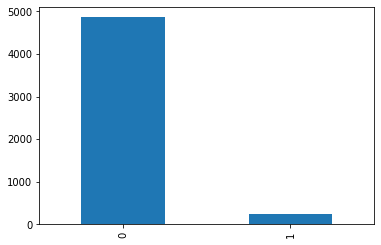

In [19]:
data['stroke'].value_counts().plot(kind = 'bar');

**Обработка категориальных признаков**

One-Hot Encoding  - кодирует значения как двоичный векторный массив.

In [20]:
delete = data.select_dtypes(include="object").columns
delete

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

Выполняем бинаризацию с помощью функции get_dummies:

In [21]:
data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',], drop_first=True)

In [22]:
data

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,51676,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,28.1,0,0,1,0,1,0,0,1,0,1,0
5106,44873,81.0,0,0,125.20,40.0,0,0,1,0,0,1,0,1,0,1,0
5107,19723,35.0,0,0,82.99,30.6,0,0,1,0,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.29,25.6,0,1,1,0,1,0,0,0,1,0,0


#Деление выборки на обучающую и тестовую

Выборку разбиваем на:
1.   тестовую - 30%
2.   обучающую - 70%



In [23]:
X = data.drop('stroke',axis=1)
y = data['stroke']

In [24]:
print(X.shape)
print(y.shape)

(5107, 16)
(5107,)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25, stratify=y)

N_test, _ = X_test.shape
N_train, _ = X_train.shape 

N_test, N_train

(1533, 3574)

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [30]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Обучаем классификатор

In [32]:
mlp_model = MLPClassifier(
                          hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 25,
                          max_iter = 1500)

In [33]:
%%time
mlp_model.fit(X_train_scaled, y_train)

CPU times: user 31.8 s, sys: 22.4 s, total: 54.2 s
Wall time: 27.7 s


MLPClassifier(max_iter=1500, random_state=25, solver='lbfgs')

#Проверка качество классификатора

In [34]:
y_train_pred = mlp_model.predict(X_train_scaled)
y_test_pred = mlp_model.predict(X_test)

print(f'Train = {accuracy_score(y_train, y_train_pred)}')
print(f'Test = {accuracy_score(y_test, y_test_pred)}')

Train = 1.0
Test = 0.9517286366601435


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#Гиперпараметры

Подберем оптимальное значение параметра регуляризации alpha. В качестве solver возьмем оптимизатор из семейства квазиньютоновских методов - lbfgs. Так как у нас небольшой набор данных, то он может сходиться быстрее, чем популярный adam. В качестве функции активации выберем Relu. А в качетве метрики оценки классификатора - accuracy_score.


In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [ ]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:

    mlp_model = MLPClassifier(
                              alpha = alpha, 
                              hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', 
                              activation = 'relu', 
                              max_iter=1500, 
                              random_state = 25)
    
    mlp_model.fit(X_train_scaled, y_train)

    y_train_pred = mlp_model.predict(X_train_scaled)
    y_test_pred = mlp_model.predict(X_test_scaled)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Минимальное значение ошибки
Train: Min error = 0.0
Number of neurons = 0.001
Test: Min error = 0.047619047619047616
Number of neurons = 1.7782794100389228


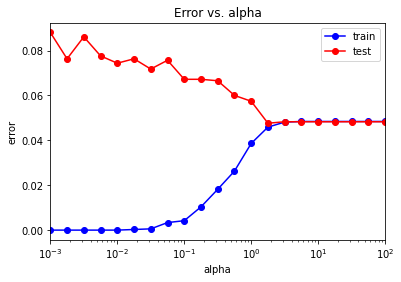

In [37]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

print("Минимальное значение ошибки")
print(f'Train: Min error = {np.min(train_err)}')
print(f'Number of neurons = {alpha_arr[np.argmin(train_err)]}')

print(f'Test: Min error = {np.min(test_err)}')
print(f'Number of neurons = {alpha_arr[np.argmin(test_err)]}')


**Рассмотрим, как менялась метрика в зависимости от гиперпараметра:**

Train: Max accuracy = 1.0
Number of neurons = 0.001
Test: Max accuracy = 0.9523809523809523
Number of neurons = 1.7782794100389228


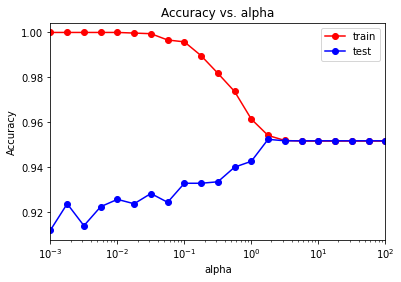

In [38]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

print(f'Train: Max accuracy = {np.max(train_acc)}')
print(f'Number of neurons = {alpha_arr[np.argmax(train_acc)]}')

print(f'Test: Max accuracy = {np.max(test_acc)}')
print(f'Number of neurons = {alpha_arr[np.argmax(test_acc)]}')

Из графика можно заметить, что при alpha < 2 (+-) наблюдается переобучение. А начиная с alpha_opt точность на обучающей и тестовой выборках совпадает. Это оптимальное значение для параметра регуляризации.

**Оптимальное значение alpha:**

In [39]:
min_test_err = np.min(test_err)
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.77827941]


In [40]:
alpha_opt = alpha_opt[0]
alpha_opt

1.7782794100389228

#Классификатор при найденном оптимальном значении alpha

In [ ]:
mlp_model = MLPClassifier(
                          alpha = alpha_opt, 
                          hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'relu', 
                          random_state = 25, 
                          max_iter = 1500)

mlp_model.fit(X_train_scaled, y_train)

y_train_pred = mlp_model.predict(X_train_scaled)
y_test_pred = mlp_model.predict(X_test_scaled)


In [43]:
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.04588696138780078
0.047619047619047616


In [44]:
print(f'Train = {accuracy_score(y_train, y_train_pred)}')
print(f'Test = {accuracy_score(y_test, y_test_pred)}')

Train = 0.9541130386121992
Test = 0.9523809523809523


#Матрица рассогласования


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [46]:
print(confusion_matrix(y_test_pred, y_test))


[[1456   70]
 [   3    4]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


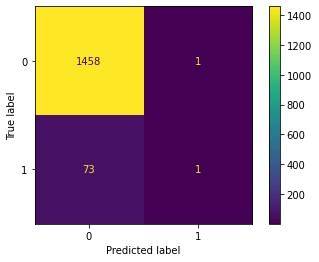

In [47]:
plot_confusion_matrix(mlp_model, X_test, y_test) 

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1459
           1       0.57      0.05      0.10        74

    accuracy                           0.95      1533
   macro avg       0.76      0.53      0.54      1533
weighted avg       0.94      0.95      0.93      1533



##Подбор числа нейронов в однослойной сети

In [ ]:
count_arr = (np.linspace(1, 100, 80)).astype(int)

test_err = []
train_err = []
train_acc = []
test_acc = []

for i in count_arr:

    mlp_model = MLPClassifier(
                              alpha = alpha_opt,
                              hidden_layer_sizes = (i,), 
                              solver = 'lbfgs', 
                              activation = 'relu', 
                              max_iter=1500, 
                              random_state = 25)
    
    mlp_model.fit(X_train_scaled, y_train)

    y_train_pred = mlp_model.predict(X_train_scaled)
    y_test_pred = mlp_model.predict(X_test_scaled)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Train: Min error = 0.04476776720761052
Number of neurons = 81
Test: Min error = 0.046314416177429873
Number of neurons = 22


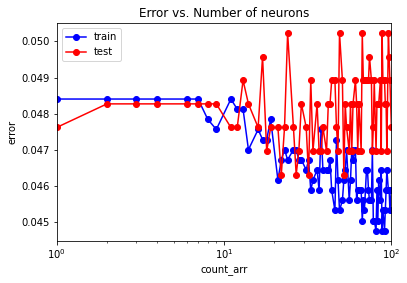

In [51]:
plt.semilogx(count_arr, train_err, 'b-o', label = 'train')
plt.semilogx(count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(count_arr), np.max(count_arr)])
plt.title('Error vs. Number of neurons')
plt.xlabel('count_arr')
plt.ylabel('error')
plt.legend()

print(f'Train: Min error = {np.min(train_err)}')
print(f'Number of neurons = {count_arr[np.argmin(train_err)]}')

print(f'Test: Min error = {np.min(test_err)}')
print(f'Number of neurons = {count_arr[np.argmin(test_err)]}')


###Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

Train: Max accuracy = 0.9552322327923894
Number of neurons = 81
Test: Max accuracy = 0.9536855838225701
Number of neurons = 22


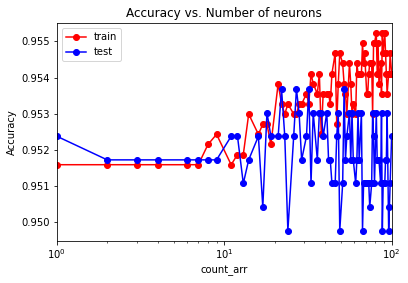

In [52]:
plt.semilogx(count_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(count_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(count_arr), np.max(count_arr)])
plt.title('Accuracy vs. Number of neurons')
plt.xlabel('count_arr')
plt.ylabel('Accuracy')
plt.legend()

print(f'Train: Max accuracy = {np.max(train_acc)}')
print(f'Number of neurons = {count_arr[np.argmax(train_acc)]}')

print(f'Test: Max accuracy = {np.max(test_acc)}')
print(f'Number of neurons = {count_arr[np.argmax(test_acc)]}')

##Подбор числа нейронов в двуслойной сети

In [ ]:
N = 12

sizes = np.linspace(1, 120, N).astype(int)

test_err = np.zeros((N, N))
train_err = np.zeros((N, N))
train_acc = np.zeros((N, N))
test_acc = np.zeros((N, N))

for i, h_l_size1 in (enumerate(sizes)):
    for j, h_l_size_2 in enumerate(sizes):

        model = MLPClassifier(
                              alpha = alpha_opt,
                              hidden_layer_sizes=(h_l_size1, h_l_size_2, ), 
                              solver='lbfgs', 
                              activation='relu', 
                              max_iter=1500, 
                              random_state=25)
        
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_err[i][j] = np.mean(y_train != y_train_pred)
        test_err[i][j] = np.mean(y_test != y_test_pred)

        train_acc[i][j] = accuracy_score(y_train, y_train_pred)
        test_acc[i][j] = accuracy_score(y_test, y_test_pred)

In [69]:
train_max_acc = np.where(train_acc == np.max(train_acc))
test_max_acc = np.where(test_acc == np.max(test_acc))

print("Train")
print(f'max accuracy = {np.max(train_acc)}')

print("Test")
print(f'max accuracy = {np.max(test_acc)}')


Train
max accuracy = 0.9893676552881925
Test
max accuracy = 0.9517286366601435
